In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [3]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='/kaggle/input/nn-vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<Functional name=vgg19, built=True>


In [4]:
def compute_content_cost(content_output, generated_output):
    
    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(tf.transpose(a_C,perm=[0,3,1,2]),shape=[m,n_C,-1])
    a_G_unrolled = tf.reshape(tf.transpose(a_G,perm=[0,3,1,2]),shape=[m,n_C,-1])

    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4 * n_H * n_W * n_C)

    return J_content

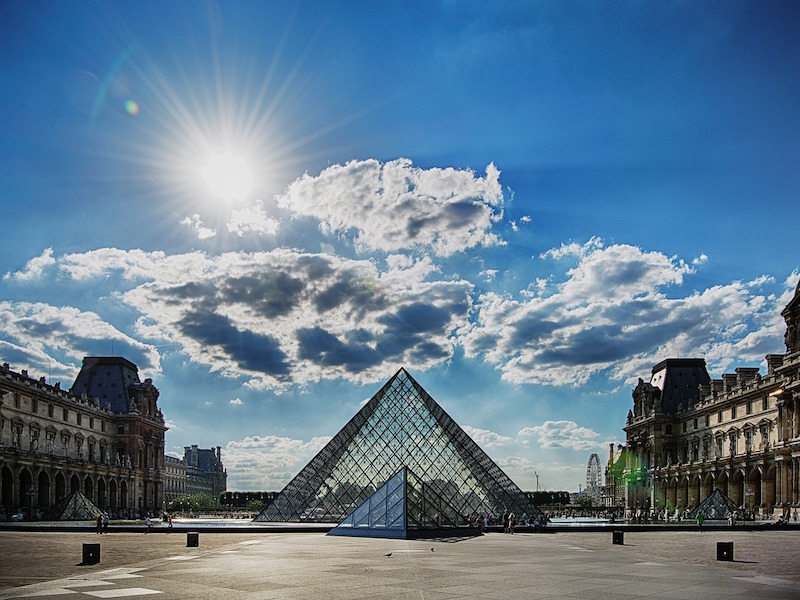

In [5]:
content_image = Image.open("/kaggle/input/imagesvgg19/images/louvre.jpg")
# content_image

In [6]:
def gram_matrix(A):

    GA = tf.matmul(A, tf.transpose(A))

    return GA

In [7]:
def compute_layer_style_cost(a_S, a_G):

    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) 
    a_S = tf.reshape(tf.transpose(a_S, perm=[0,3,1,2]), shape=[n_C,-1])
    a_G = tf.reshape(tf.transpose(a_G, perm=[0,3,1,2]), shape=[n_C,-1])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (4 * (n_C**2) * ((n_H*n_W)**2))

    return J_style_layer

In [8]:
for layer in vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
vgg.get_layer('block5_conv4').output

<KerasTensor shape=(None, 25, 25, 512), dtype=float32, sparse=False, name=keras_tensor_20>

In [10]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [11]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    
    J_style = 0

    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [12]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
   
    J = (alpha * J_content) + (beta * J_style)

    return J

(1, 400, 400, 3)


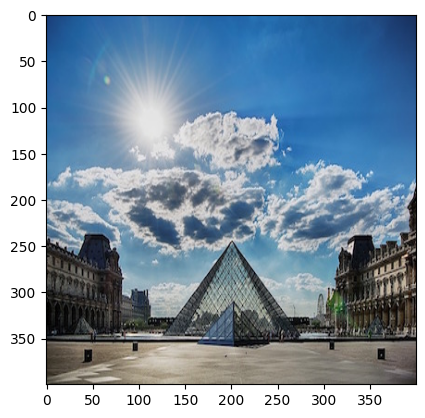

In [13]:
content_image = np.array(Image.open("/kaggle/input/imagesvgg19/images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


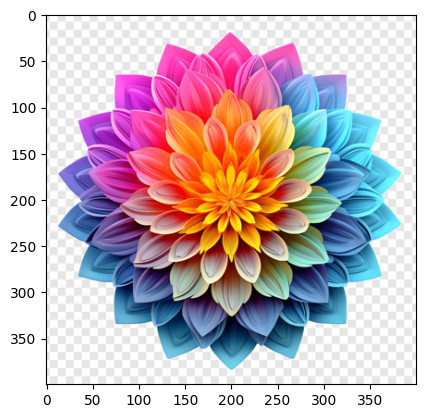

In [23]:
style_image =  np.array(Image.open("/kaggle/input/oneimage/Mandala fractal design element with flower pattern -33.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


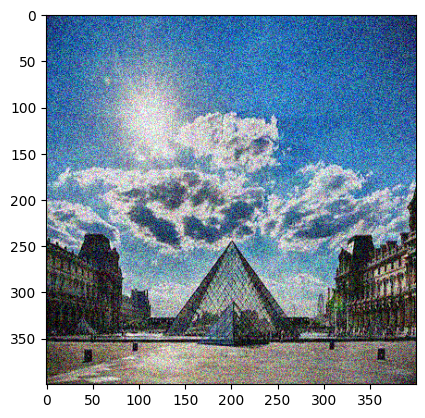

In [24]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
"""
The clip_value_min parameter is set to 0.0, and the clip_value_max parameter is set to 1.0. 
This means that any valuesin the generated_image tensor that are less than 0.0 will be set to 0.0,
and any values greater than 1.0 will be set to 1.0.
"""

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [25]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [26]:
content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [27]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [28]:
def clip_0_1(image):
   
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C

        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)

        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C,a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style)


    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

In [30]:
generated_image = tf.Variable(generated_image)

Epoch 0 


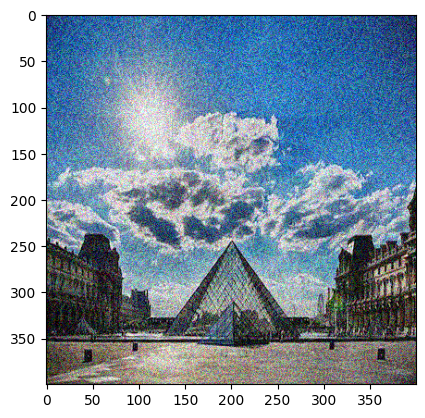

Epoch 250 


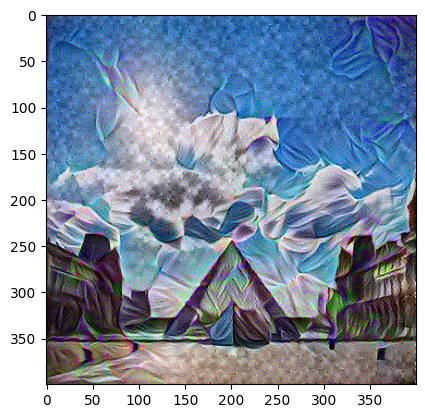

Epoch 500 


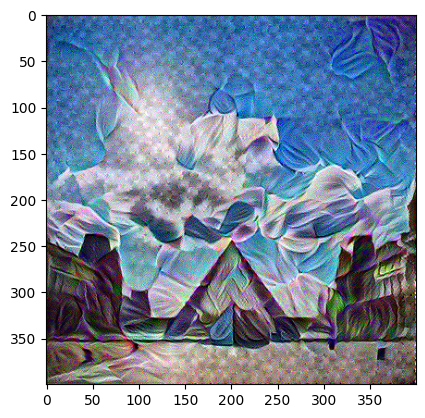

Epoch 750 


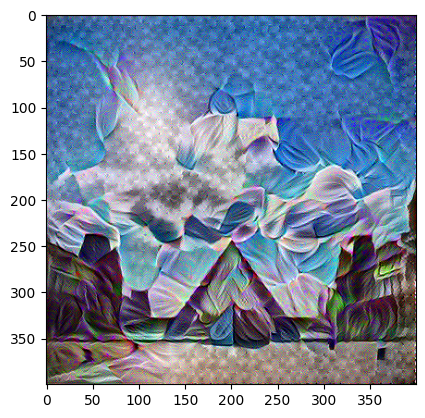

Epoch 1000 


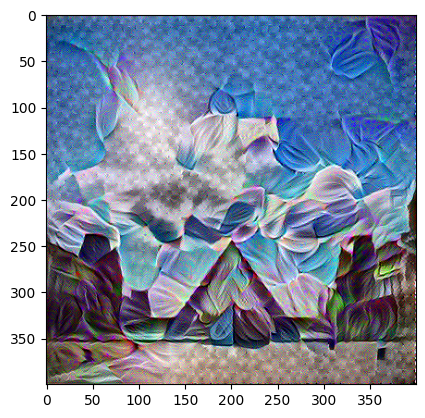

Epoch 1250 


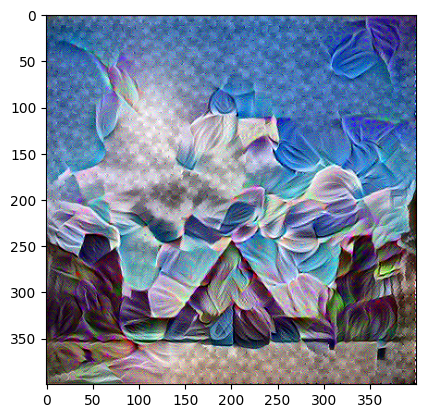

Epoch 1500 


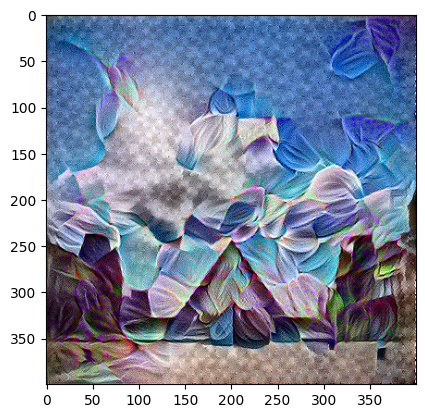

Epoch 1750 


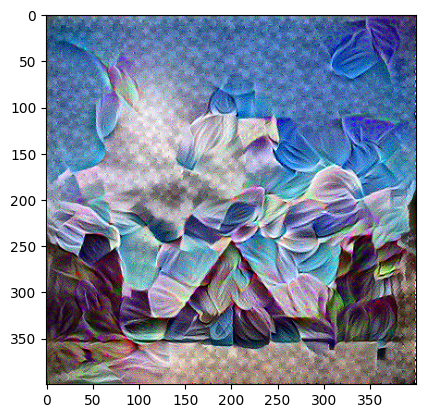

Epoch 2000 


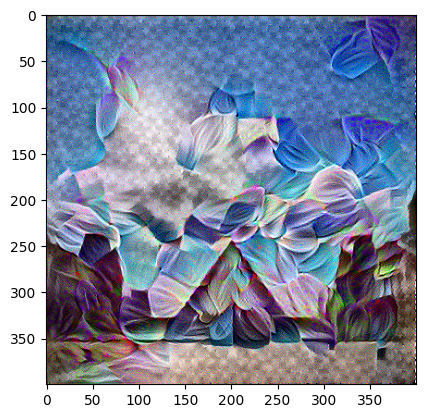

Epoch 2250 


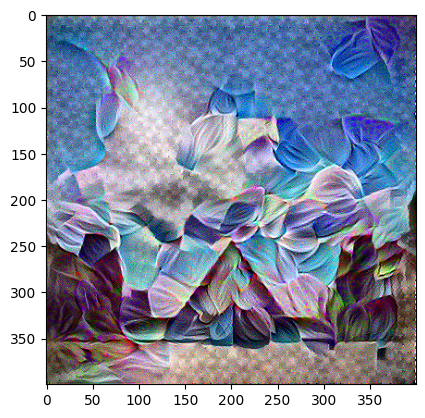

Epoch 2500 


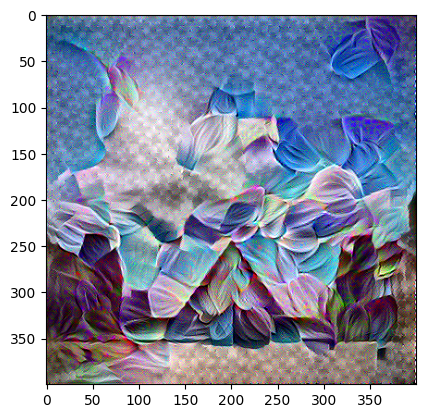

In [31]:
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"/kaggle/working/image_{i}.jpg")
        plt.show()

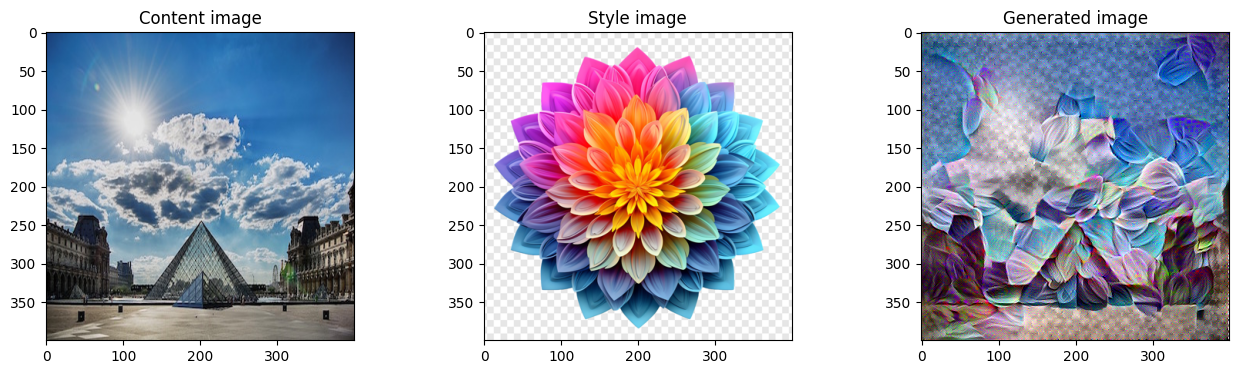

In [32]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()